In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

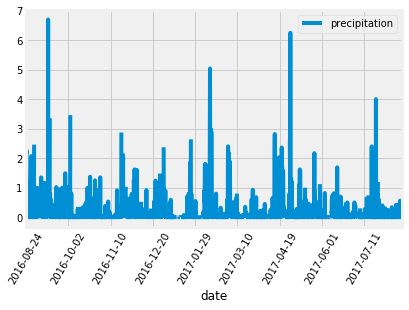

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

last_year = dt.date(2017,8,23) - dt.timedelta(days = 365)


# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

prec_scores = session.query(measurement.date, measurement.prcp).filter(measurement.date>last_year).all()


# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(prec_scores, columns = ['date', 'precipitation'])
#results = results + 1

# Sort the dataframe by date

df.set_index(['date'], inplace=True)
df.sort_values(['date'], inplace=True)
#df = df.prec_data()
#df.drop(columns=['date'], inplace=True)
#df.describe()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=60)

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(station.station)).all()

[(9)]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?

active_station = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).\
order_by(func.count(measurement.station).desc()).all()
active_station

# List the stations and the counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
active_station[0][0]

'USC00519281'

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

lowest = func.min(measurement.tobs)

highest = func.max(measurement.tobs)

average = func.avg(measurement.tobs)

session.query(lowest, highest, average).filter(measurement.station==active_station[0][0]).all()


[(54.0, 85.0, 71.66378066378067)]

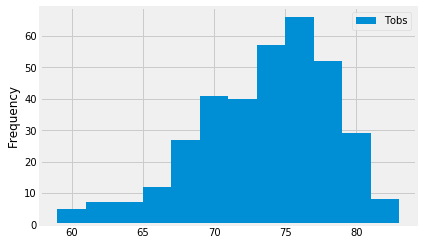

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_results = session.query(measurement.tobs).filter(measurement.station==active_station[0][0]).\
filter(measurement.date>last_year).all()
station_results

histogram_df = pd.DataFrame(station_results, columns=['Tobs'])
histogram_df

histogram_df.plot.hist(bins=12)


![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_start = dt.date(2017, 3, 5)
trip_end = dt.date(2017, 3, 20)
one_year_ago = dt.timedelta(days=365)
avg_year_ago = (calc_temps((trip_start-one_year_ago), (trip_end-one_year_ago)))
yerr = avg_year_ago[0][2] - avg_year_ago[0][0]
avg_year_ago


[(63.0, 70.5, 78.0)]

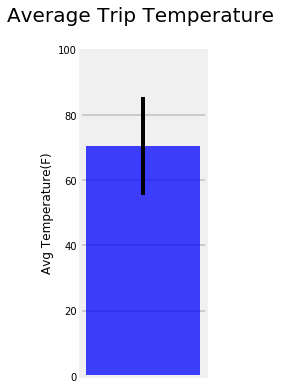

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


plt.figure(figsize=(2,6))
plt.bar(1,avg_year_ago[0][1],yerr = yerr, align='center',color='blue', alpha= .75)
plt.xticks([])
plt.ylim(0,100)
plt.ylabel("Avg Temperature(F)")
plt.grid(linestyle='-', linewidth=2,)
plt.suptitle("Average Trip Temperature", size = 20)
plt.show()

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


trip_rainfall = session.query(station.station, station.name, station.latitude, station.longitude, station.elevation, func.sum(measurement.prcp)).\
    filter(measurement.station==station.station).filter(measurement.date >= '2017-03-05').filter(measurement.date <= '2017-03-20').\
    group_by(station.station).order_by(func.sum(measurement.prcp).desc()).all()



trip_rainfall_df = pd.DataFrame(trip_rainfall, columns=['Station', 'Name & Location', 'Lat', 'Long', 'Elevation', 'Prcp'])
trip_rainfall_df

,Station,Name & Location,Lat,Long,Elevation,Prcp
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.76
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.33
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.69
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.36
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.35
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.35
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.06


## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

NameError: name 'Measurement' is not defined

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
